In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from sys import platform
is_linux = (platform == "linux" or platform == "linux2")

from glob import glob
from os import listdir, mkdir, getcwd, remove
from os.path import isfile, join, basename, isdir

from analysis.split_event_tree import split_event_tree,ttype_column
from analysis.calc import calc_nll_llr_dtf_delta, get_kinematics, filter_for_tf
from analysis.import_data import import_data,filter_data,combine_columns
from analysis.plot_matplotlib import plot_hist

import os; print(os.environ['PATH']); print(os.environ['LD_LIBRARY_PATH'])
#from analysis.cffi.Physsim.CalculateME import lib as physsim
from analysis.cffi.mg5.lib import calc_zhh, calc_zzh
from tqdm.auto import tqdm

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.vscode-server/bin/6c3e3dba23e8fadc360aed75ce363ba185c49794/bin/remote-cli:/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/bin:/nfs/dust/ilc/user/bliewert/.mambaforge/condabin:/usr/lib/heimdal/bin:/afs/desy.de/common/passwd:/usr/local/bin:/usr/bin:/afs/desy.de/user/b/bliewert/bin:/usr/local/sbin:/usr/sbin:/opt/puppetlabs/bin
/afs/desy.de/user/b/bliewert/public/ILCSoft/LCIO/lib64:/afs/desy.de/user/b/bliewert/public/ILCSoft/Physsim/lib64:/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/analysis/cffi/mg5/mg5/lib


/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
mcp_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle.npy")
reco_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco.npy")

In [15]:
from analysis.save_data import pd_to_np

recalculate = False

if recalculate:
    #tjmr_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_matchingreco/compare_truejet_matchingreco.npy")
    #tjt_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_true/compare_truejet_true.npy")
    #tjs_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_seen/compare_truejet_seen.npy")

    reco = filter_for_tf(reco_raw)
    mcp = filter_for_tf(mcp_raw, jet=False, lepton=False)
        
    for run_type in ['reco', 'mcparticle']:
        data = mcp if run_type == 'mcparticle' else reco
        
        kinematics = []
        pbar = tqdm(range(len(data)))
        for i in pbar:
            pbar.set_description(f"{run_type}: Getting kinematics for event {i}")
            for value in get_kinematics(data, run_type == 'mcparticle', i): 
                kinematics.append(value)
            
        mg5_zhh = calc_zhh(kinematics)
        mg5_zzh = calc_zzh(kinematics)

        data["zhh_mg5"] = np.array(mg5_zhh)
        data["zzh_mg5"] = np.array(mg5_zzh)
        data["llr_mg5"] = np.log(data["zhh_mg5"]/data["zzh_mg5"])

        np.save(f"/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/{run_type}/compare_{run_type}_with_mg5.npy", pd_to_np(data))
        
else:
    mcp  = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle_with_mg5.npy", allow_pickle=True))
    reco = pd.DataFrame(np.load("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco_with_mg5.npy", allow_pickle=True))

In [16]:
from analysis.plot_routines import plot_llr
from analysis.calc import calc_nll_llr_dtf_delta

calc_nll_llr_dtf_delta(mcp)
calc_nll_llr_dtf_delta(reco)

/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/nfs/dust/ilc/user/bliewert/.mambaforge/envs/py311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,run,event,error_code,is_zhh,is_zzh,passed_preselection,true_h1_decay_pdg,true_h2_decay_pdg,true_z2_decay_pdg,misclustering_region,...,zzh_costhetaz1f,zzh_costhetaz2f,zzh_sigmalr,true_type,zhh_mg5,zzh_mg5,llr_mg5,zhh_nll,zzh_nll,llr
0,403001,15004,0,1,0,1,5,5,0,0,...,-0.953963,0.847487,1.137333e-21,zhh,2.051033e-19,9.840972e-19,-1.568211,48.381416,45.737289,-2.644127
1,403001,15009,0,1,0,1,5,5,0,5,...,0.664132,0.577706,6.446027e-21,zhh,4.793727e-21,3.375226e-19,-4.254324,52.582626,46.909321,-5.673306
2,403001,15015,0,1,0,1,5,5,0,1,...,0.692472,0.411261,1.013659e-21,zhh,5.085620e-24,2.844255e-22,-4.024054,59.474022,51.948914,-7.525109
3,403001,15017,1200,1,0,1,5,4,0,5,...,0.000000,0.000000,0.000000e+00,zhh,7.601317e-22,1.152686e-20,-2.718943,inf,inf,NaN
4,403001,15019,0,1,0,1,5,5,0,5,...,-0.411834,0.469661,1.722427e-22,zhh,3.827669e-22,1.113671e-19,-5.673161,54.962341,48.877476,-6.084869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30378,403011,84194,0,0,1,1,5,0,5,0,...,-0.810050,0.938608,9.117404e-17,zzh,1.533044e-19,1.278416e-14,-11.331292,48.368053,34.008896,-14.359159
30379,403011,84197,0,0,1,1,5,0,5,6,...,-0.157652,0.454723,4.183166e-22,zzh,6.723765e-23,1.478049e-18,-9.998000,55.192608,49.965832,-5.226777
30380,403011,84201,0,0,1,1,5,0,5,1,...,-0.403353,0.325295,8.818137e-23,zzh,1.912776e-25,4.634948e-20,-12.397995,59.359440,50.510624,-8.848816
30381,403011,84225,0,0,1,1,5,0,5,0,...,0.365337,0.447441,2.751964e-22,zzh,2.080641e-23,2.290804e-19,-9.306567,55.736809,49.200592,-6.536216


In [23]:
reco = calc_nll_llr_dtf_delta(filter_data(reco))
mcp = calc_nll_llr_dtf_delta(filter_data(mcp))

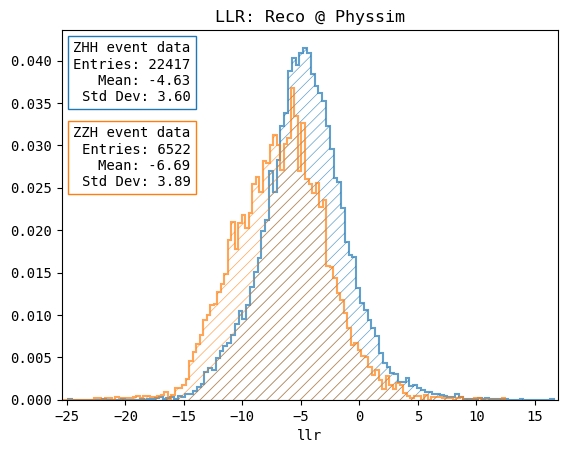

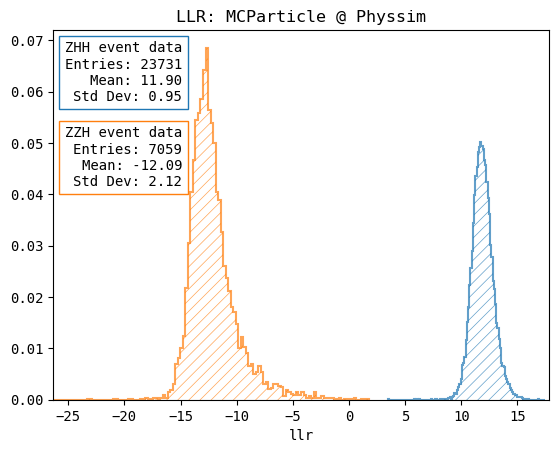

In [28]:
plot_llr(reco, "Reco @ Physsim")
plot_llr(mcp, "MCParticle @ Physsim")

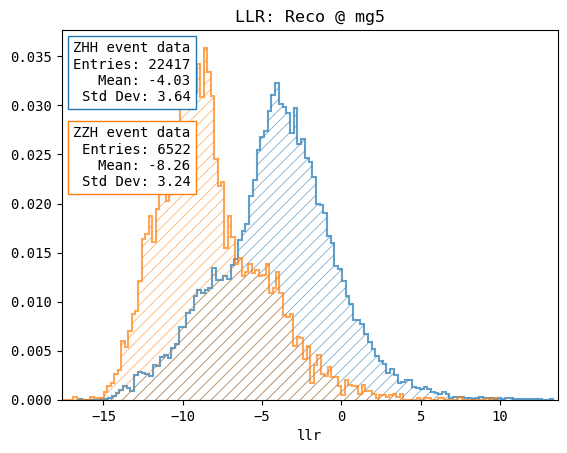

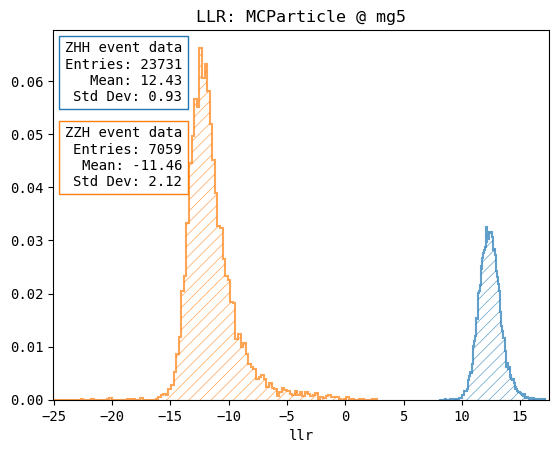

In [29]:
plot_llr(reco, "Reco @ mg5", llr_column='llr_mg5')
plot_llr(mcp, "MCParticle @ mg5", llr_column='llr_mg5')

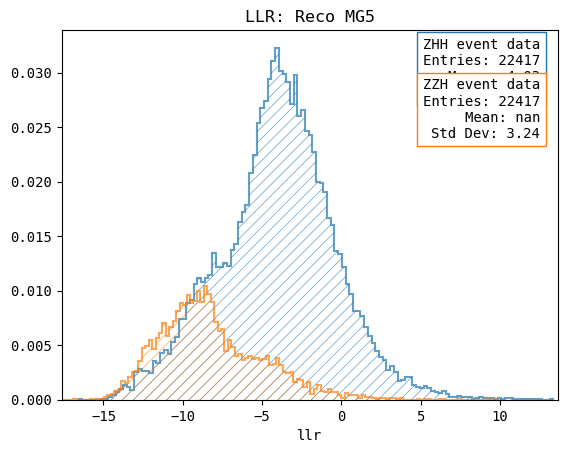

In [28]:
plot_llr(data[(data["parton1_pdg"] == 5) & ((data["parton3_pdg"] == 5))], "Reco MG5", llr_column="llr_mg5")

In [33]:
np.average(data["llr_mg5"]/data["llr"])

1.0

In [17]:
mcp_raw.keys()

Index(['run', 'event', 'error_code', 'is_zhh', 'is_zzh', 'passed_preselection',
       'true_h1_decay_pdg', 'true_h2_decay_pdg', 'true_z2_decay_pdg',
       'parton1_pdg',
       ...
       'zzh_phi', 'zzh_phiz', 'zzh_phiz1f', 'zzh_phiz2f', 'zzh_costheta',
       'zzh_costhetaz', 'zzh_costhetaz1f', 'zzh_costhetaz2f', 'zzh_sigmalr',
       'true_type'],
      dtype='object', length=102)

In [8]:
data["reco"].shape

(29249, 112)

In [14]:
from analysis.energy_transfer import plot_jet_energy_transfer_from_df, plot_energy_transfer

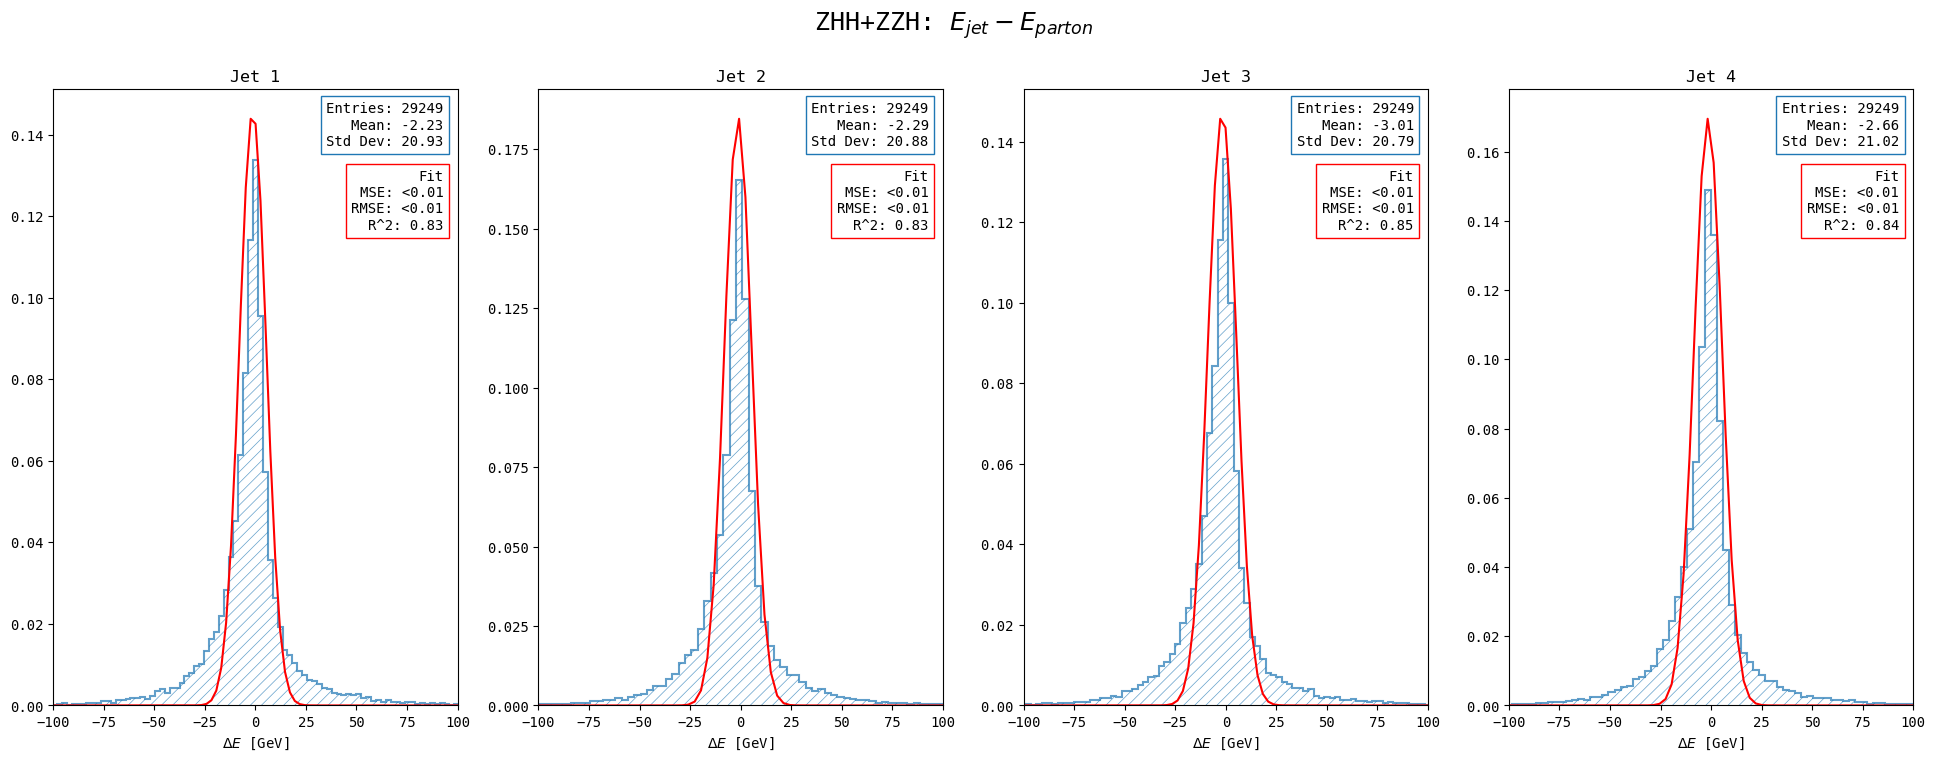

In [15]:
plot_jet_energy_transfer_from_df(reco, "ZHH+ZZH")

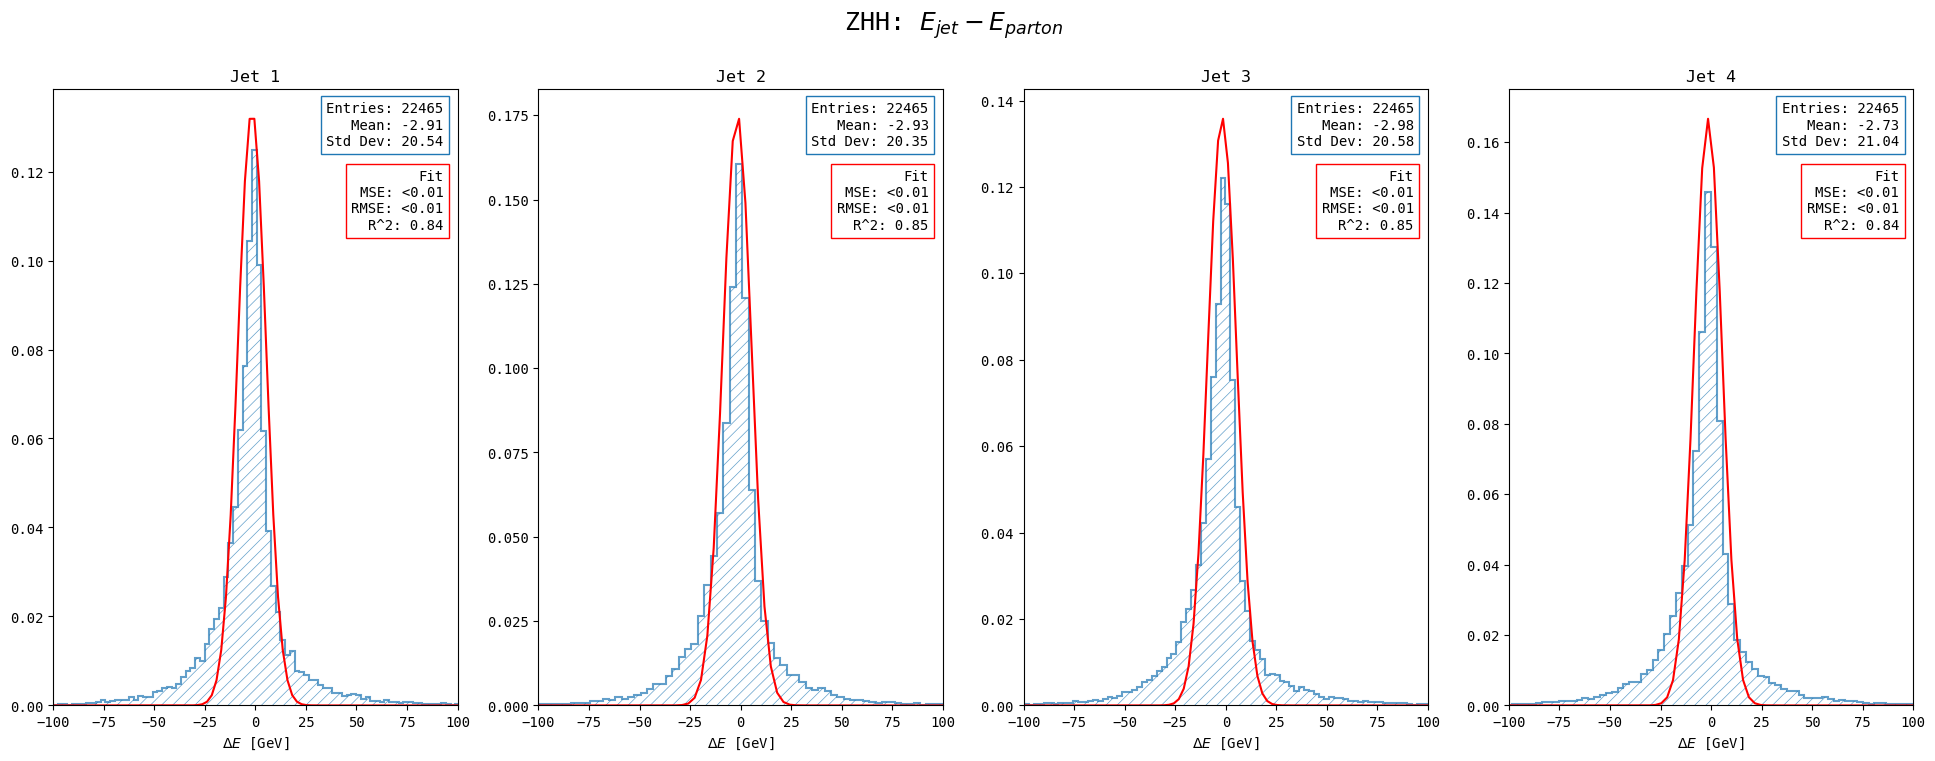

In [16]:
plot_jet_energy_transfer_from_df(reco[reco["is_zhh"] == 1], "ZHH")

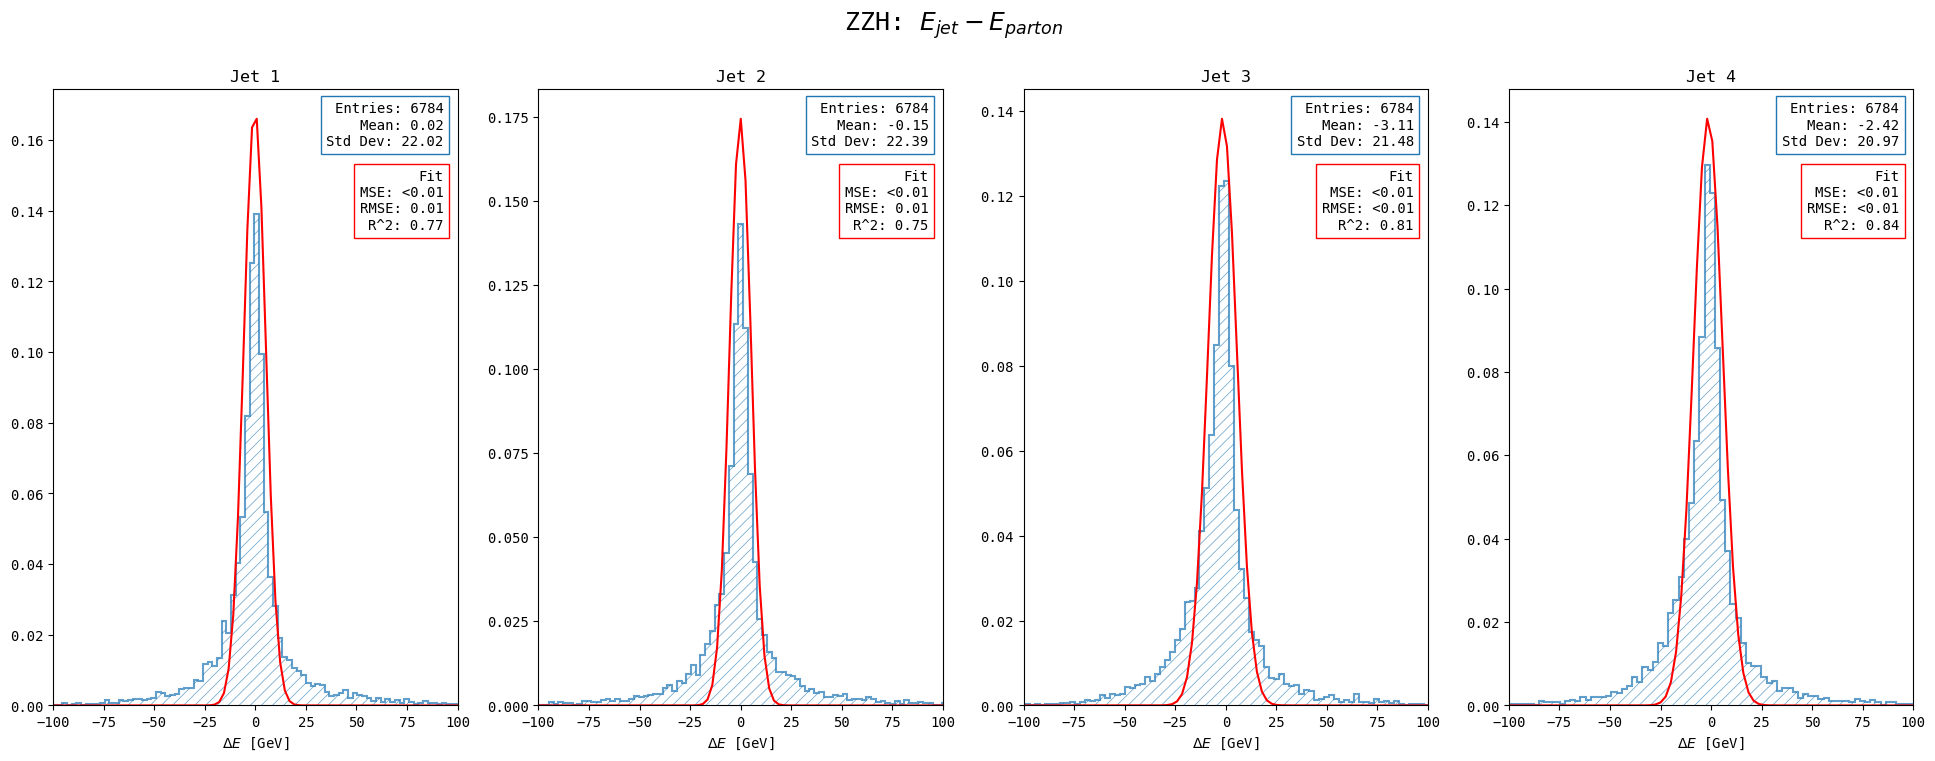

In [17]:
plot_jet_energy_transfer_from_df(reco[reco["is_zzh"] == 1], "ZZH")

In [21]:
" ".join(reco.keys())

'run event error_code is_zhh is_zzh passed_preselection true_h1_decay_pdg true_h2_decay_pdg true_z2_decay_pdg misclustering_region misclustering_region_icns efrac1_reco efrac2_reco efrac1_true efrac2_true efrac1_icn_reco efrac2_icn_reco efrac1_icn_true efrac2_icn_true parton1_pdg parton2_pdg parton3_pdg parton4_pdg parton1_e parton2_e parton3_e parton4_e true_lep1_e true_lep2_e jet1_e jet2_e jet3_e jet4_e lep1_e lep2_e parton1_px parton1_py parton1_pz parton2_px parton2_py parton2_pz parton3_px parton3_py parton3_pz parton4_px parton4_py parton4_pz true_lep1_px true_lep1_py true_lep1_pz true_lep2_px true_lep2_py true_lep2_pz jet1_px jet1_py jet1_pz jet2_px jet2_py jet2_pz jet3_px jet3_py jet3_pz jet4_px jet4_py jet4_pz lep1_px lep1_py lep1_pz lep2_px lep2_py lep2_pz h1_decay_pdg h2_decay_pdg z2_decay_pdg zhh_sigma zhh_sigmall zhh_sigmalr zhh_sigmarl zhh_sigmarr zhh_mz zhh_mhh zhh_mzhh zhh_phi zhh_phif zhh_phih zhh_costheta zhh_costhetaf zhh_costhetah zzh_sigma zzh_sigmalll zzh_sigmallr

In [32]:
import click

import matplotlib.pyplot as plt
import logging
logger = logging.getLogger('mem_hep')

from analysis.import_data import import_data, filter_data
from analysis.plot_matplotlib import plot_hist
from math import sqrt, pow, pi
from typing import Optional
from os import path as osp
from os import makedirs, remove
import numpy as np

def plot_energy_transfer(data, name, plot_save_dir:Optional[str] = None, fit = "gauss", true_label = "parton", reco_label = "jet", quantity="E"):
    from scipy.optimize import curve_fit
    
    fig, axes = plt.subplots(1, len(data), figsize=(6*len(data),8))
    fig.suptitle(name + r": $" + quantity + r"_{" + reco_label + r"}-" + quantity +  r"_{" + true_label + r"}$", fontsize=18)
    
    for i in range(1,1+len(data)):
        n_bins = 128
        df = data[i-1]
        
        y, bins = np.histogram(df, bins=n_bins)
        x = (bins[:-1] + bins[1:]) / 2
        
        def bw(x, N, x0, G):
            return N*G/((2*pi)*((x-x0)**2 + ((G**2)/4)))
        
        def gauss(x, a, x0, sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))
        
        fit_func = bw if fit == "bw" else gauss
        
        init_bw = [len(df), np.average(df), 1]
        init_gauss = [len(df), np.average(df), np.std(df)]
        
        popt, pcov = curve_fit(fit_func, x, y, p0 = (init_bw if fit_func == bw else init_gauss))

        plot_hist(df, f"{reco_label.title()} {i}", fit_func=lambda x: fit_func(x, *popt), fit_opts=popt, bins=n_bins, xlim=(-100,100), ax=axes[i-1], xlabel=r"$ΔE$ [GeV]", title=f"{reco_label.title()} {i}", normalize=True, yscale="linear")
        #sns.histplot(data["jet{}_e".format(i)] - data["parton{}_e".format(i)], bins=128, ax=axes[i-1]).set_title("Jet {}".format(i))
        
    if plot_save_dir is not None:
        plot_path = osp.join(plot_save_dir, f"{name}.png")
        if osp.isfile(plot_path):
            remove(plot_path)
        
        fig.savefig(plot_path)
    else:
        plt.show()
        
    plt.close(fig)

def plot_jet_energy_transfer_from_df(data, name = "", plot_save_dir:Optional[str] = None, fit = "gauss"):
    df = []
    for i in range(1, 5):
        df.append(data["jet{}_e".format(i)] - data["parton{}_e".format(i)])
    
    plot_energy_transfer(df , name, plot_save_dir=plot_save_dir, fit=fit)

def plot_jet_energy_transfer_from_file(reco_npy_path:str, plots_path:str):
    import pandas as pd
    
    reco = filter_data(import_data(reco_npy_path), check_only_error=True)
    
    # Transfer function analysis for reco
    reco = reco[((reco["parton1_e"] > 0) & (reco["parton2_e"] > 0) & (reco["parton3_e"] > 0) & (reco["parton4_e"] > 0) )]
    reco = reco[((   reco["jet1_e"] > 0) & (   reco["jet2_e"] > 0) & (   reco["jet3_e"] > 0) & (   reco["jet4_e"] > 0) )]
    
    if not osp.isdir(plots_path):
        makedirs(plots_path)
    
    plot_jet_energy_transfer_from_df(reco, "ZHH+ZZH", plots_path)
    plot_jet_energy_transfer_from_df(reco[reco["is_zhh"] == 1], "ZHH", plots_path)
    plot_jet_energy_transfer_from_df(reco[reco["is_zzh"] == 1], "ZZH", plots_path)


In [23]:
reco["true_lep1_e"]

0        136.986847
1         35.332821
2         33.199898
3        122.403229
4        116.665054
            ...    
29244     29.358374
29245    113.307274
29246     39.028950
29247     62.153835
29248    107.027115
Name: true_lep1_e, Length: 29249, dtype: float32

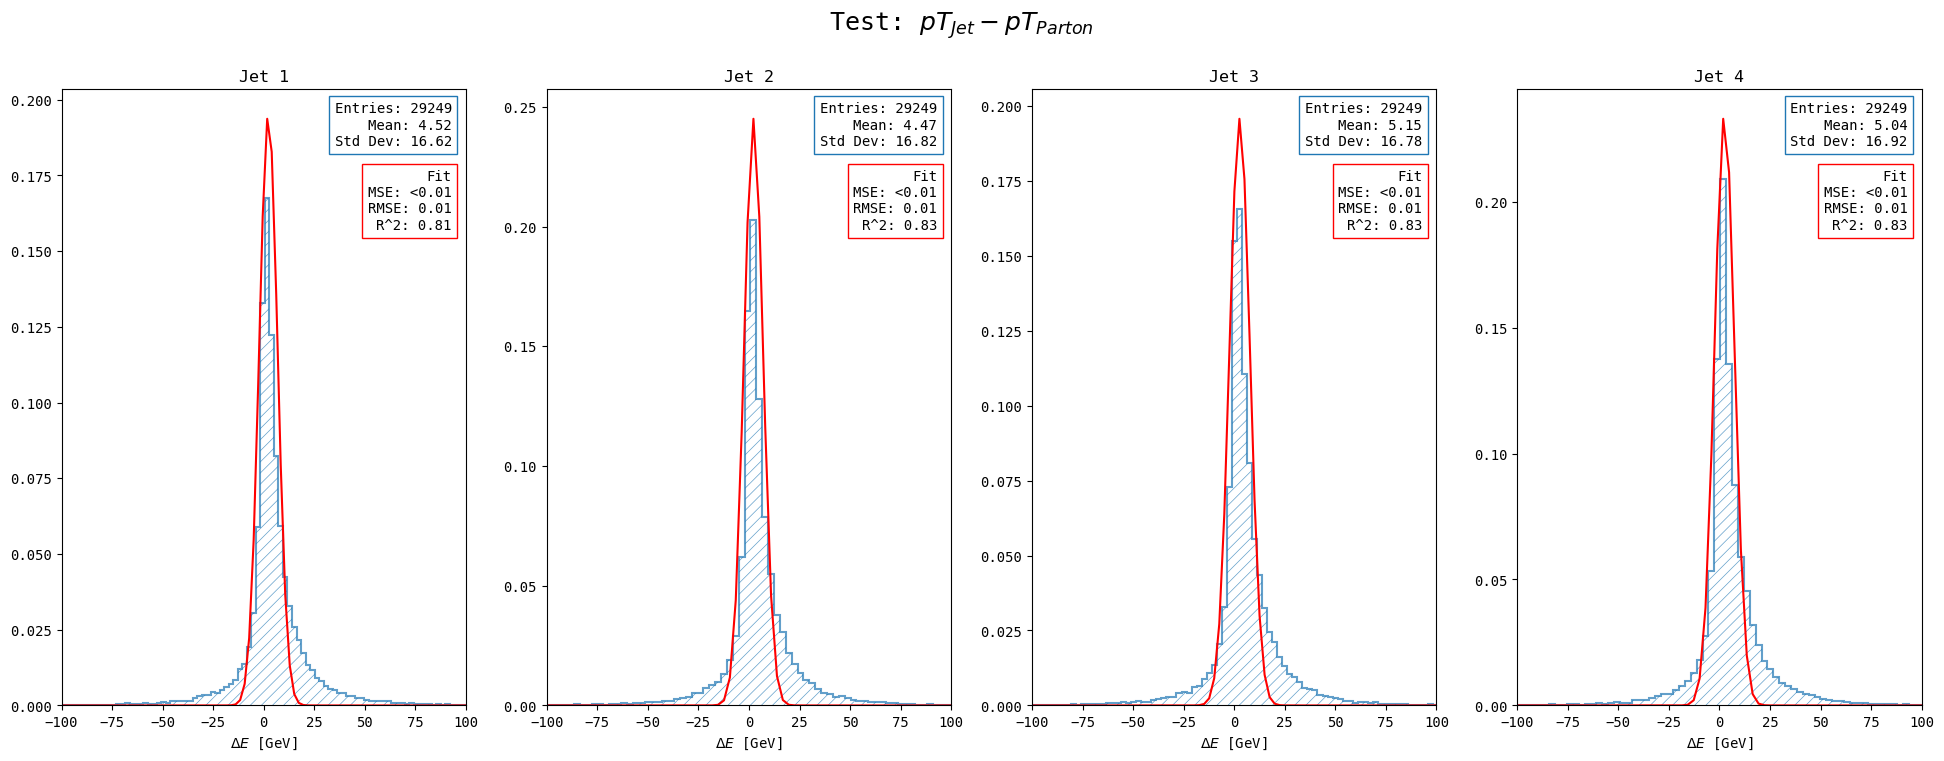

In [33]:
df = []
for i in range(1, 5):
    df.append(
        np.sqrt(reco["parton{}_px".format(i)]**2 + reco["parton{}_py".format(i)] ** 2) - 
        np.sqrt(reco["jet{}_px".format(i)]**2 + reco["jet{}_py".format(i)] ** 2)
    )

plot_energy_transfer(df , "Test", fit="gauss", true_label="Parton", reco_label="Jet", quantity="pT")

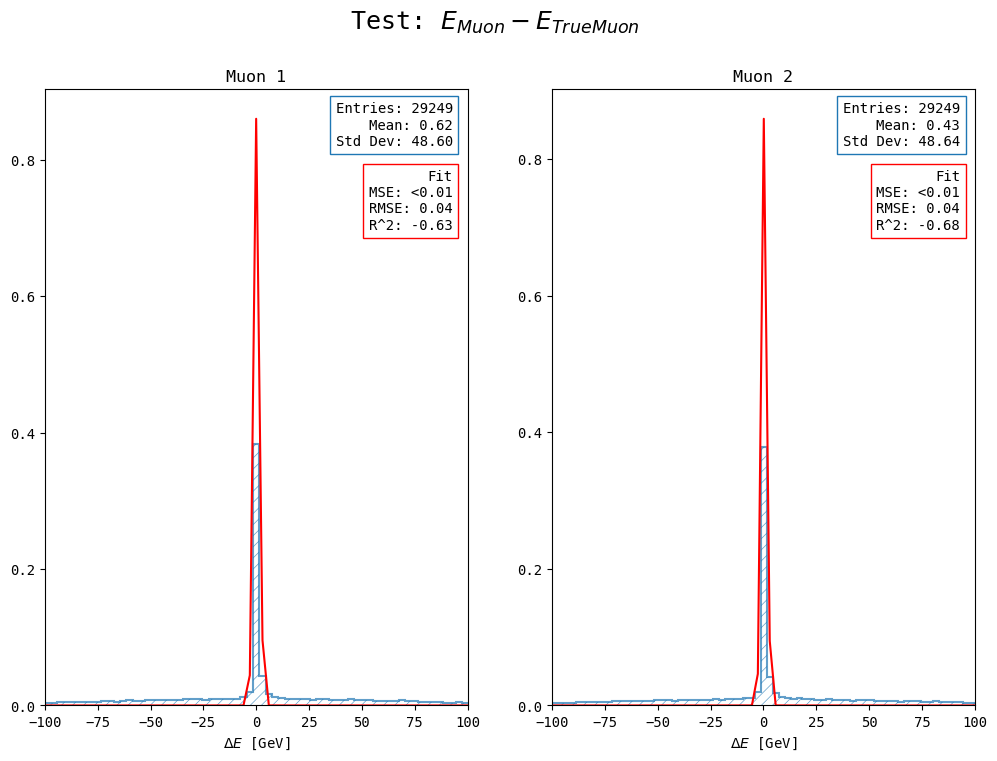

In [30]:
df = []
for i in range(1, 3):
    df.append(reco["true_lep{}_e".format(i)] - reco["lep{}_e".format(i)])

plot_energy_transfer(df , "Test", fit="gauss", true_label="True Muon", reco_label="Muon")

In [29]:
tjs_raw[""]

KeyError: ''

In [323]:
c = root_to_numpy("C:\DevRepositories\MEM_HEP\compare_out.root", "dataTree", merge_with_np_array=a, join_by=["run", "event"], merge_columns=["zzh_h_e"])

('zzh_h_e', 'float32')


<Axes: xlabel='misclustering_region_icns', ylabel='count'>

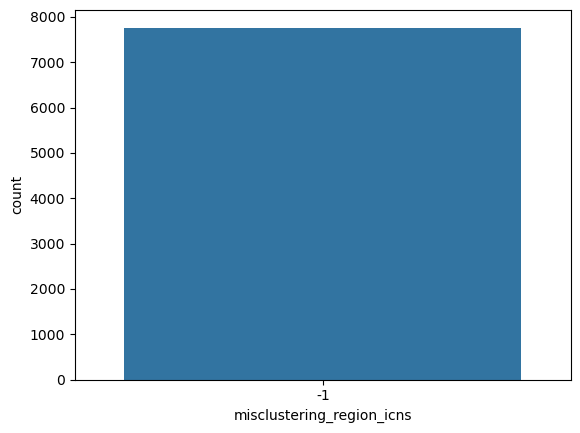

In [11]:
sns.countplot(data_reco, x="misclustering_region_icns")

<Axes: xlabel='efrac2_reco', ylabel='efrac2_true'>

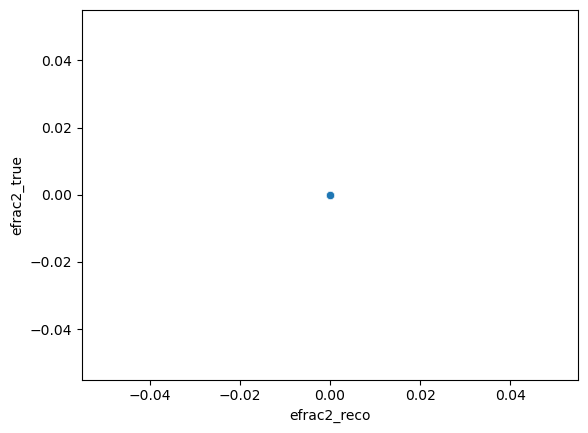

In [7]:
sns.scatterplot(data_reco, x="efrac1_reco", y="efrac1_true")

Comparing all (raw) and filtered (data) events

Text(0.5, 1.0, 'TrueJet / ZZH')

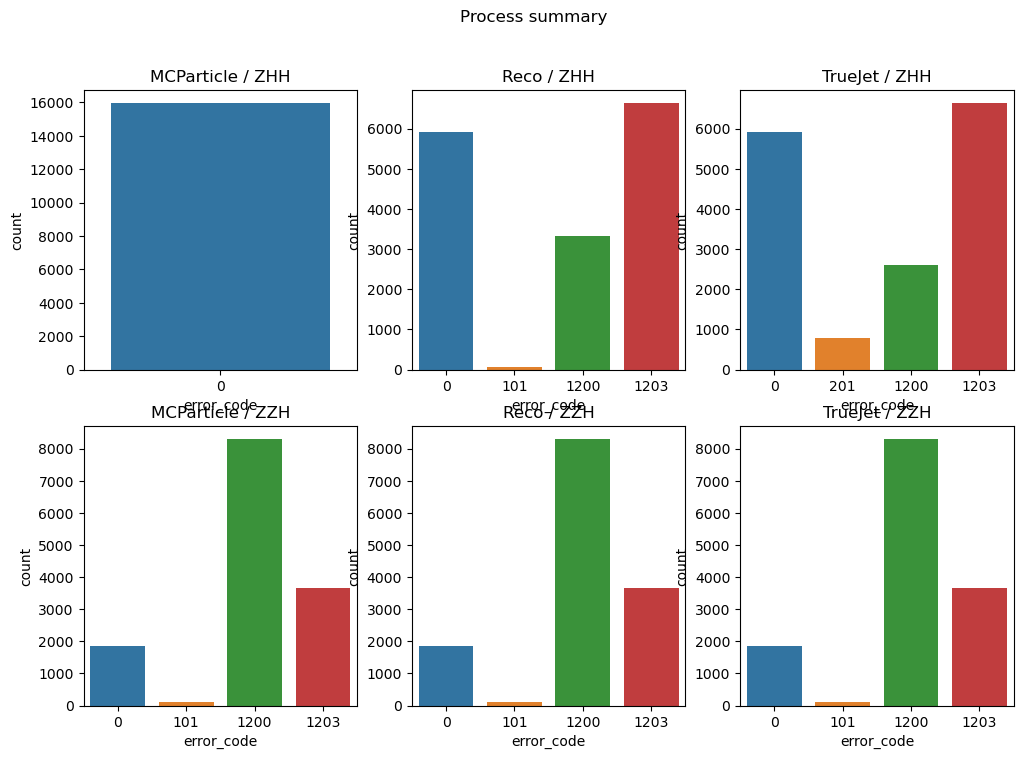

In [8]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle("Process summary")

fig1 = sns.countplot(raw_mcparticle[raw_mcparticle["is_zhh"] == 1], x="error_code", ax=ax11)
fig1.set_title("MCParticle / ZHH")

fig2 = sns.countplot(raw_reco[raw_reco["is_zhh"] == 1], x="error_code", ax=ax12)
fig2.set_title("Reco / ZHH")

fig3 = sns.countplot(raw_truejet[raw_truejet["is_zhh"] == 1], x="error_code", ax=ax13)
fig3.set_title("TrueJet / ZHH")

fig4 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax21)
fig4.set_title("MCParticle / ZZH")

fig5 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax22)
fig5.set_title("Reco / ZZH")

fig6 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax23)
fig6.set_title("TrueJet / ZZH")

<Axes: xlabel='zzh_nll', ylabel='Count'>

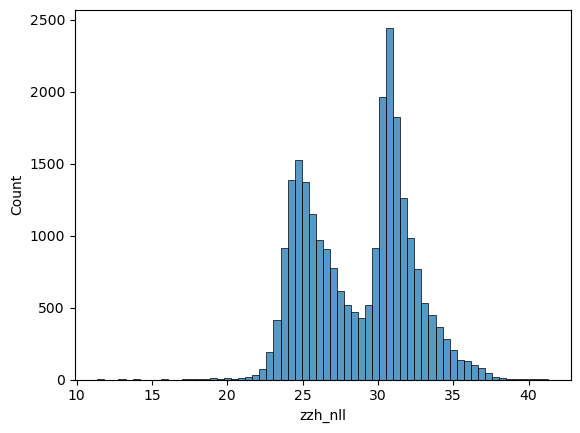

In [7]:
sns.histplot(data_mcparticle, x="zzh_nll", bins=64)

<Axes: xlabel='h1_decay_pdg', ylabel='count'>

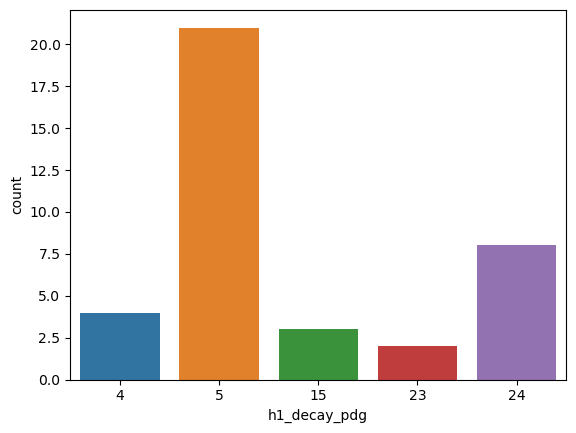

In [13]:
sns.countplot(data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["error_code"] == 0)], x="h1_decay_pdg")

1. MCTruth

In [6]:
true_zzh = data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()
true_zhh = data_mcparticle[(data_mcparticle["is_zhh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

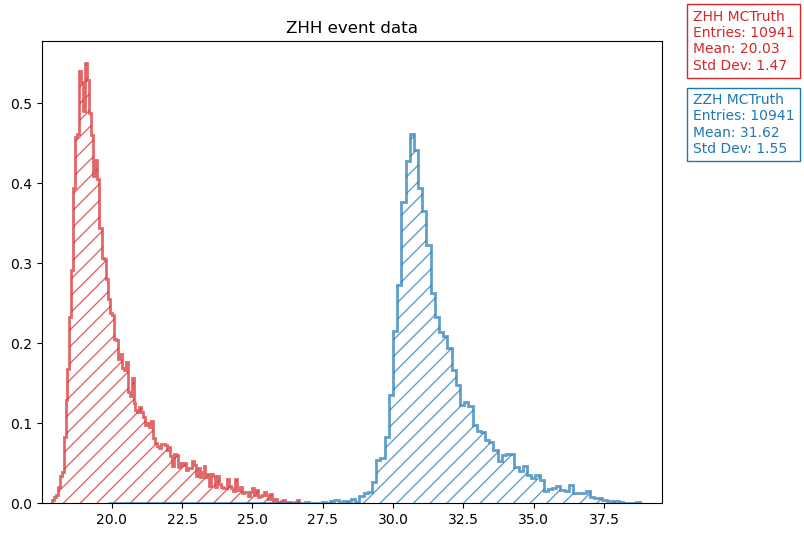

In [40]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

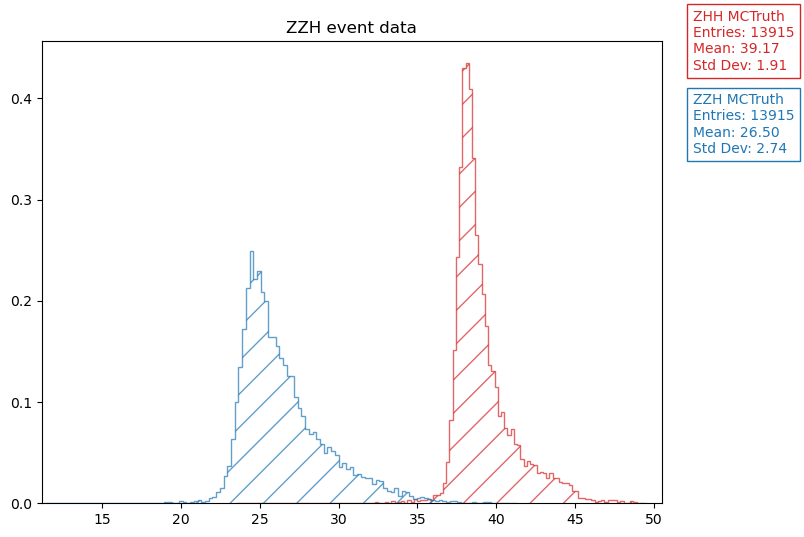

In [36]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

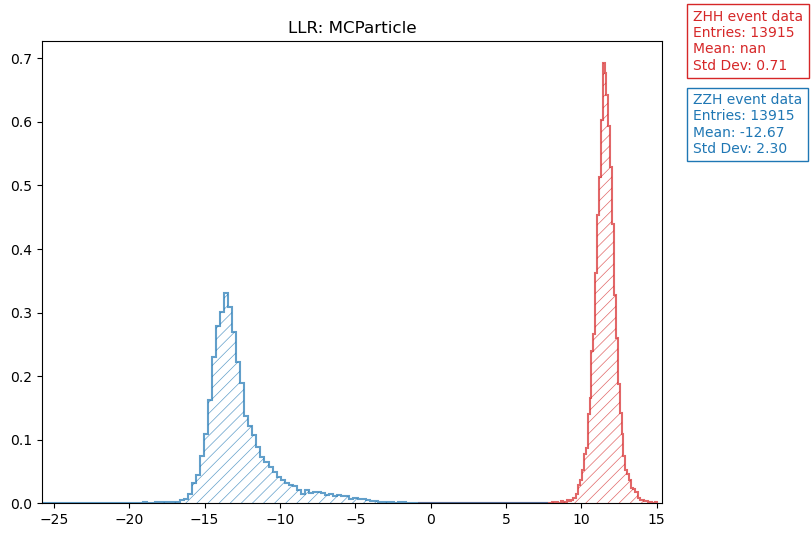

In [7]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: MCParticle", normalize=True, xlabel="llr")

2. RefinedJets

In [55]:
true_zzh = data_reco[(data_reco["is_zzh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()
true_zhh = data_reco[(data_reco["is_zhh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

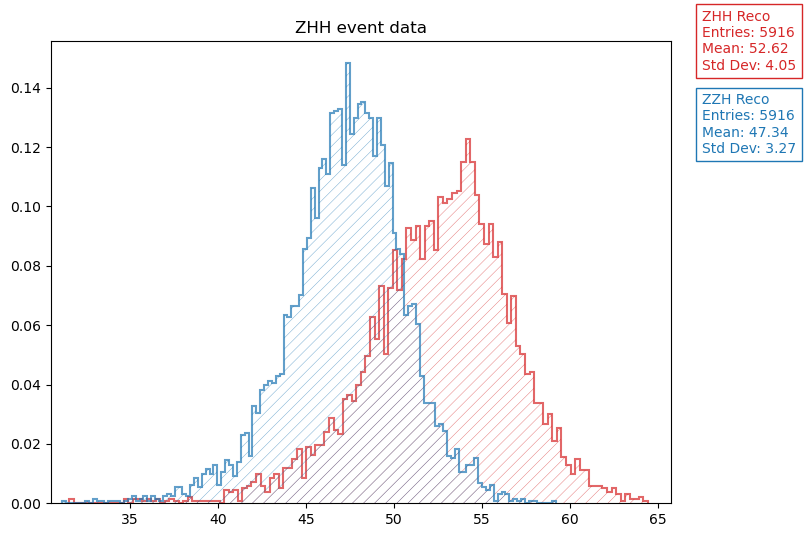

In [57]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

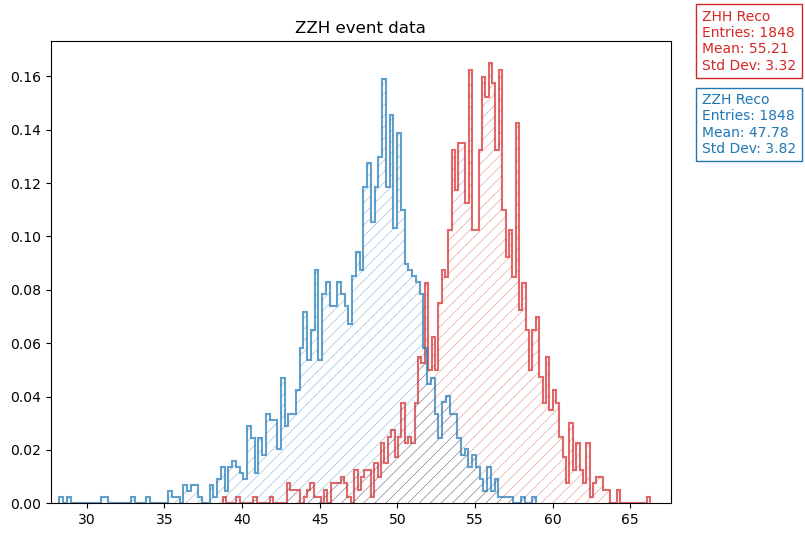

In [58]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

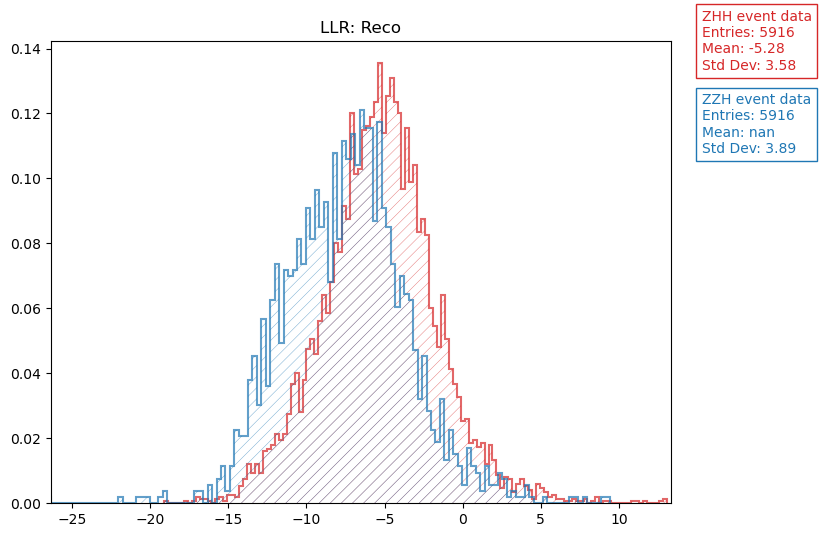

In [59]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH event data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH event data (Potential memory leak).


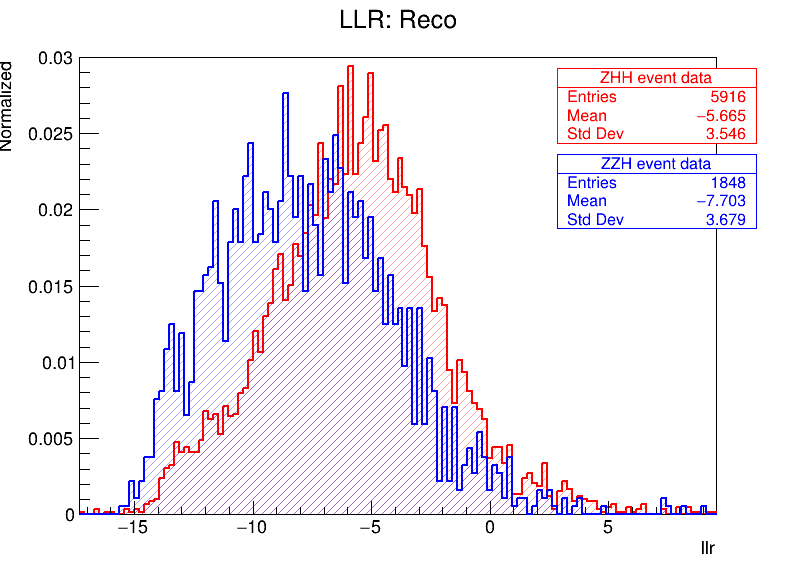

In [ ]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

3. TrueJet

In [60]:
true_zzh = data_truejet[(data_truejet["is_zzh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()
true_zhh = data_truejet[(data_truejet["is_zhh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

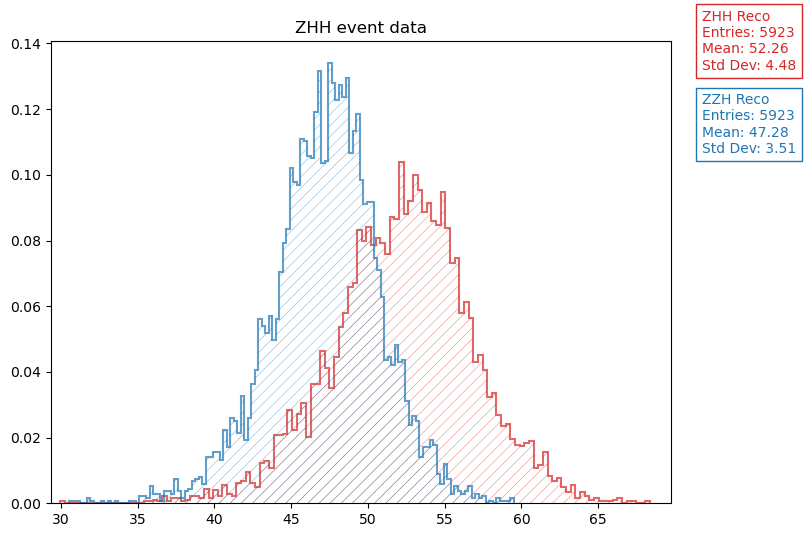

In [61]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

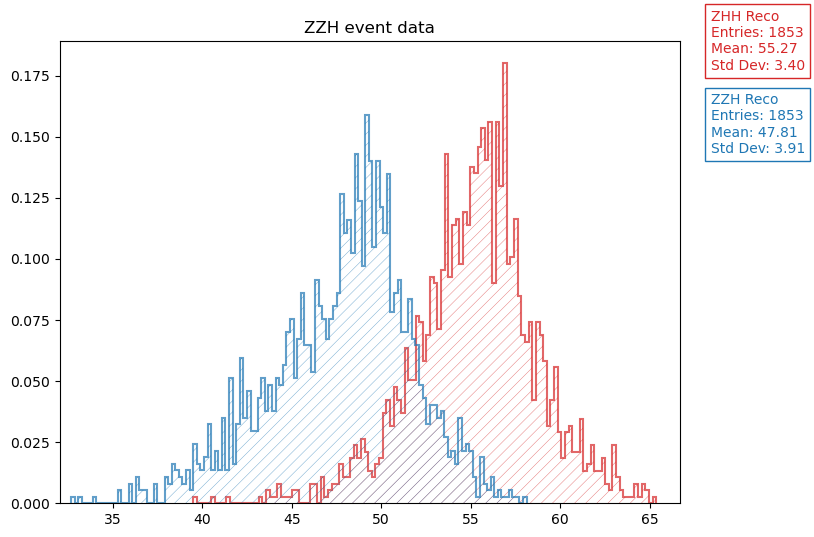

In [62]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

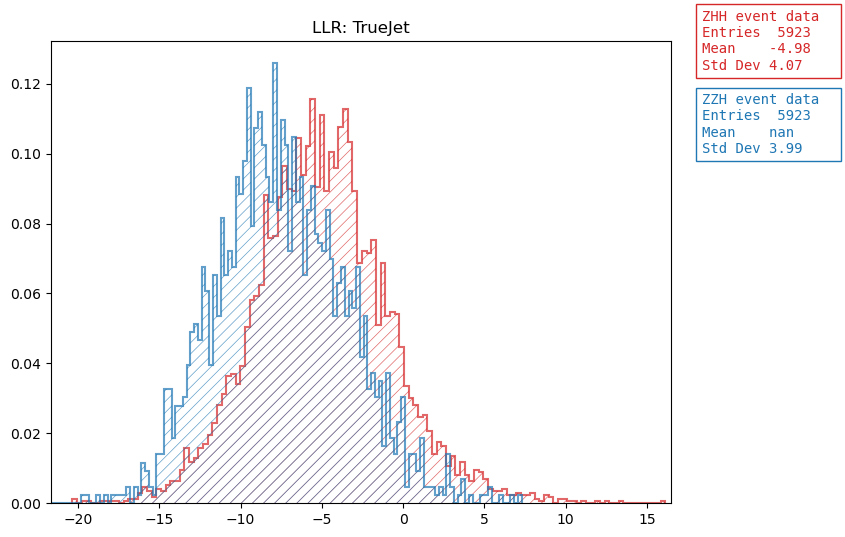

In [85]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: TrueJet", normalize=True, xlabel="llr")

Region A

<Axes: xlabel='true_type', ylabel='count'>

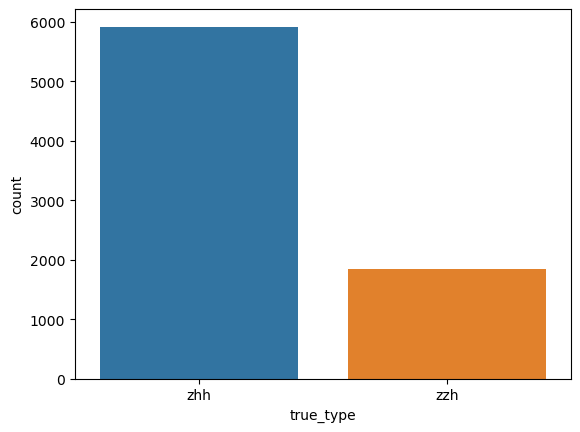

: 

In [ ]:
sns.countplot(data_reco, x="true_type")

<Axes: xlabel='misclustering_region_icns', ylabel='count'>

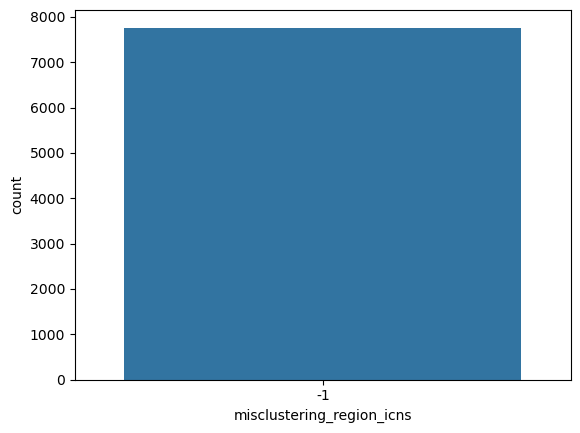

In [14]:
sns.countplot(data_reco, x="misclustering_region") # {"AA",0.}, {"AB",1.}, {"AC",2.}, {"AD",3.}, {"BB",4.}, {"BC",5.}, {"BD",6.}, {"CC",7.}, {"CD",8.}, {"DD",9.}

In [ ]:
data_reco.columns

Index(['run', 'event', 'error_code', 'is_zhh', 'is_zzh', 'passed_preselection',
       'true_h1_decay_pdg', 'true_h2_decay_pdg', 'true_z2_decay_pdg',
       'misclustering_region', 'misclustering_region_icns', 'h1_decay_pdg',
       'h2_decay_pdg', 'z2_decay_pdg', 'zhh_sigma', 'zhh_sigmall',
       'zhh_sigmalr', 'zhh_sigmarl', 'zhh_sigmarr', 'zhh_mz', 'zhh_mhh',
       'zhh_mzhh', 'zhh_phi', 'zhh_phif', 'zhh_phih', 'zhh_costheta',
       'zhh_costhetaf', 'zhh_costhetah', 'zzh_sigma', 'zzh_sigmalll',
       'zzh_sigmallr', 'zzh_sigmalrl', 'zzh_sigmalrr', 'zzh_sigmarrr',
       'zzh_sigmarrl', 'zzh_sigmarlr', 'zzh_sigmarll', 'zzh_mz1', 'zzh_mz2',
       'zzh_mzz', 'zzh_mzzh', 'zzh_mh', 'zzh_phi', 'zzh_phiz', 'zzh_phiz1f',
       'zzh_phiz2f', 'zzh_costheta', 'zzh_costhetaz', 'zzh_costhetaz1f',
       'zzh_costhetaz2f', 'zzh_sigmalr', 'true_type', 'zhh_nll', 'zzh_nll',
       'llr'],
      dtype='object')

In [8]:
misclustering_region = 0
data = data_reco

true_zzh = data[(data["is_zzh"] == 1) & (data["zhh_sigmalr"] > 0) & (data["zzh_sigmalr"] > 0) & (data["misclustering_region"] == misclustering_region)].copy()
true_zhh = data[(data["is_zhh"] == 1) & (data["zhh_sigmalr"] > 0) & (data["zzh_sigmalr"] > 0) & (data["misclustering_region"] == misclustering_region)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

In [12]:
llr

,zhh_llr,zzh_llr


/nfs/dust/ilc/user/bliewert/.miniconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/nfs/dust/ilc/user/bliewert/.miniconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Axis limits cannot be NaN or Inf

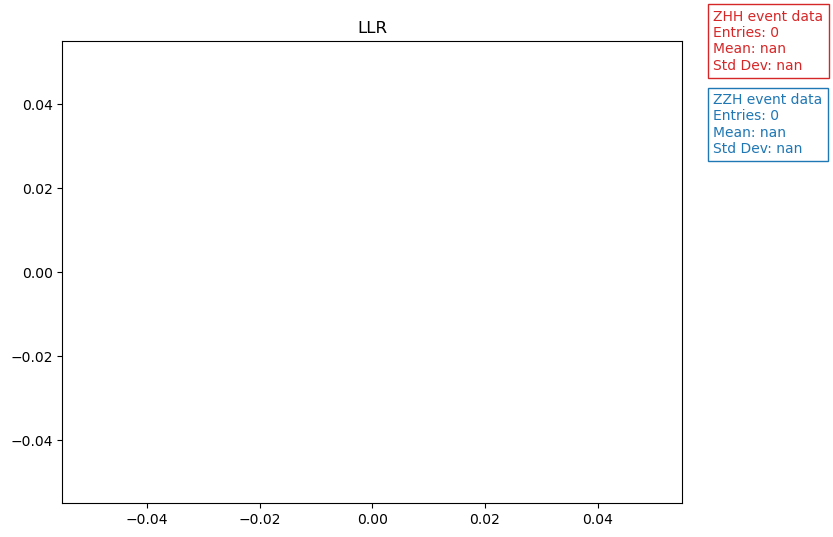

In [10]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR", normalize=True, xlabel="llr")